In [20]:
from functools import partial
import numpy as np
import scipy.integrate
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [26]:
scenarios = [
     {"a":-.3, "b":1.4, "tau":20, "I":0},
     {"a":-.3, "b":1.4, "tau":20, "I":0.23},
     {"a":-.3, "b":1.4, "tau":20, "I":0.5}
]
time_span = np.linspace(0, 200, num=1500)

In [27]:
def fitzhugh_nagumo(x, t, a, b, tau, I):
    """Time derivative of the Fitzhugh-Nagumo neural model.
    Args:
       x (array size 2): [Membrane potential, Recovery variable]
       a, b (float): Parameters.
       tau (float): Time scale.
       t (float): Time (Not used: autonomous system)
       I (float): Constant stimulus current. 
    Return: dx/dt (array size 2)
    """
    return np.array([x[0] - x[0]**3 - x[1] + I, 
                     (x[0] - a - b * x[1])/tau])

In [28]:
def get_displacement(param, dmax=0.5,time_span=np.linspace(0,200, 1000), number=20):
    # We start from the resting point...
    ic = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=[0,0],
                                                      t= np.linspace(0,999, 1000))[-1]
    # and do some displacement of the potential. 
    traj = [] 
    for displacement in np.linspace(0,dmax, number):
        traj.append(scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=ic+np.array([displacement,0]),
                                                      t=time_span))
    return traj

In [29]:
trajectories = {} # We store the trajectories in a dictionnary, it is easier to recover them. 
for i,param in enumerate(scenarios):
    trajectories[i] = get_displacement(param, number=3, time_span=time_span, dmax=0.5)

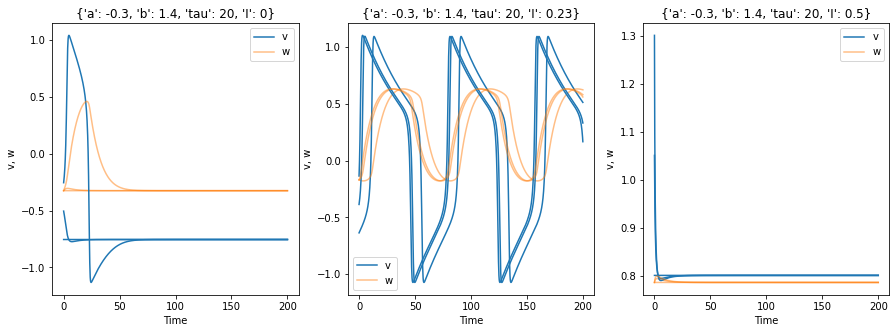

In [30]:
fig, ax = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios),5))
for i,param in enumerate(scenarios):
        ax[i].set(xlabel='Time', ylabel='v, w',
                     title='{}'.format(param))
        for j in range(len(trajectories[i])):
            v = ax[i].plot(time_span,trajectories[i][j][:,0], color='C0')
            w = ax[i].plot(time_span,trajectories[i][j][:,1], color='C1', alpha=.5)
        ax[i].legend([v[0],w[0]],['v','w'])

In [37]:
def plot_isocline(ax, a, b, tau, I, style='--', opacity=.75, vmin=-1,vmax=1):
    """Plot the null iscolines of the Fitzhugh nagumo system"""
    v = np.linspace(vmin,vmax,100)
    ax.plot(v, v - v**3 + I, style, color='r', alpha=opacity)
    ax.plot(v, (v - a)/b, style, color='b', alpha=opacity)

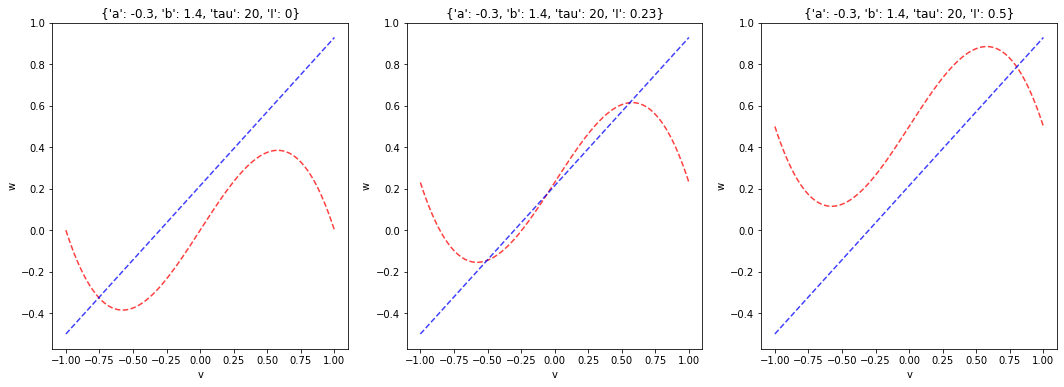

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, sc in enumerate(scenarios):
    plot_isocline(ax[i], **sc)
    ax[i].set(xlabel='v', ylabel='w',
              title='{}'.format(sc))

In [40]:
def plot_vector_field(ax, param, xrange, yrange, steps=50):
    # Compute the vector field
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dx,dy = fitzhugh_nagumo([X,Y],0,**param)   
    
    # streamplot is an alternative to quiver 
    # that looks nicer when your vector filed is
    # continuous.
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.5))
    
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

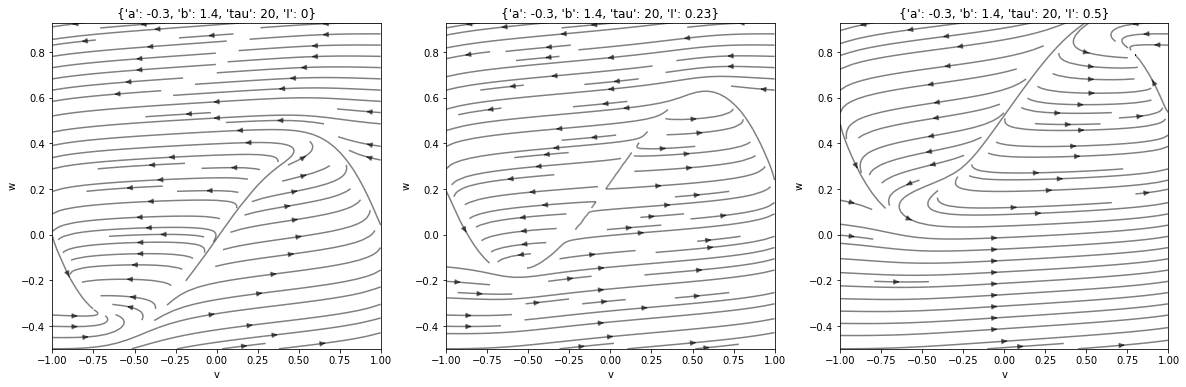

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, sc in enumerate(scenarios):
    xrange = (-1, 1)
    yrange = [(1/sc['b'])*(x-sc['a']) for x in xrange]
    plot_vector_field(ax[i], sc, xrange, yrange)
    ax[i].set(xlabel='v', ylabel='w',
          title='{}'.format(sc))

In [12]:
def plot_phase_diagram(param, ax=None, title=None):
    """Plot a complete Fitzhugh-Nagumo phase Diagram in ax.
    Including isoclines, flow vector field, equilibria and their stability"""
    if ax is None:
        ax = plt.gca()
    if title is None:
        title = "Phase space, {}".format(param) 
    
    ax.set(xlabel='v', ylabel='w', title=title)
        
    # Isocline and flow... 
    xlimit = (-1.5, 1.5)
    ylimit = (-.6, .9)
    plot_vector_field(ax, param, xlimit, ylimit)
    plot_isocline(ax, **param, vmin=xlimit[0],vmax=xlimit[1])
    
    # Plot the equilibria 
    eqnproot = find_roots(**param)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **param)) for e in eqnproot] 
    for e,n in zip(eqnproot,eqstability):
        ax.scatter(*e, color=EQUILIBRIUM_COLOR[n])
        
        # Show a small perturbation of the stable equilibria...
        time_span = np.linspace(0, 200, num=1500)
        if n[:6] == 'Stable':
            for perturb in (0.1, 0.6):
                ic = [e[0]+abs(perturb*e[0]),e[1]]
                traj = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                  y0=ic,
                                                  t=time_span)
                ax.plot(traj[:,0], traj[:,1])

    # Legend
    labels = frozenset(eqstability)
    ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
           loc='lower right')

In [46]:
def find_roots(a,b,I, tau):
    # The coeficients of the polynomial equation are:
    # 1           * v**3 
    # 0           * v**2 
    # - (1/b - 1) * v**1 
    # - (a/b + I) * v**0
    coef = [1, 0, 1/b - 1, - a/b - I]
    
    # We are only interested in real roots.
    # np.isreal(x) returns True only if x is real. 
    # The following line filter the list returned by np.roots
    # and only keep the real values. 
    roots = [np.real(r) for r in np.roots(coef) if np.isreal(r)]
    
    # We store the position of the equilibrium. 
    return [[r, r - r**3 + I] for r in roots]

eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

In [43]:
EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center':'C5'}

In [44]:
def jacobian_fitznagumo(v, w, a, b, tau, I):
    """ Jacobian matrix of the ODE system modeling Fitzhugh-Nagumo's excitable system
    Args
    ====
        v (float): Membrane potential
        w (float): Recovery variable
        a,b (float): Parameters
        tau (float): Recovery timescale.
    Return: np.array 2x2"""
    return np.array([[- 3 * v**2 + 1 , -1],
                       [1/tau, -b/tau]])

In [45]:
def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Use the eigenvalues. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point.
    """
    
    eigv = np.linalg.eigvals(jacobian)
    
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

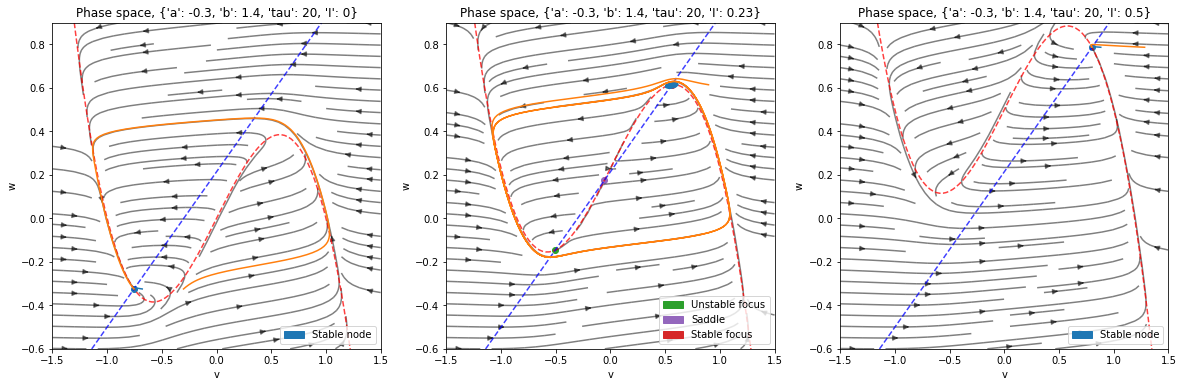

In [47]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
for i, param in enumerate(scenarios):
    plot_phase_diagram(param, ax[i])

In [48]:
ispan = np.linspace(0,0.5,200)
bspan = np.linspace(0.6,2,200)

In [49]:
I_list = []
eqs_list = []
nature_legends = []
trace = []
det = []

for I in ispan:
    param = {'I': I, 'a': -0.3, 'b': 1.4, 'tau': 20}
    roots = find_roots(**param)
    for v,w in roots:
        J = jacobian_fitznagumo(v,w, **param)
        nature = stability(J)
        nature_legends.append(nature)
        I_list.append(I)
        eqs_list.append(v)
        det.append(np.linalg.det(J))
        trace.append(J[0,0]+J[1,1])

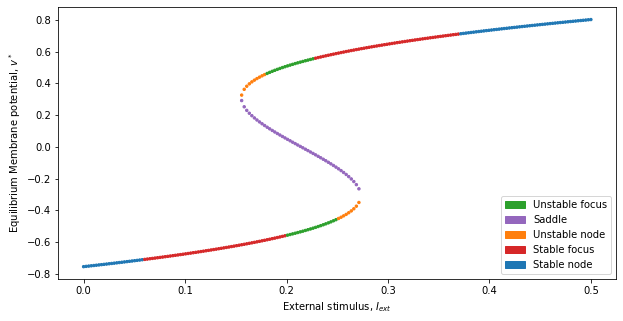

In [50]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
labels = frozenset(nature_legends)
ax.scatter(I_list, eqs_list, c=[EQUILIBRIUM_COLOR[n] for n in nature_legends], s=5.9)  
ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
               loc='lower right')
ax.set(xlabel='External stimulus, $I_{ext}$', 
       ylabel='Equilibrium Membrane potential, $v^*$');

Text(0.5, 1.0, "Equilibrium trajectory in the jacobian's Trace/Determinant space")

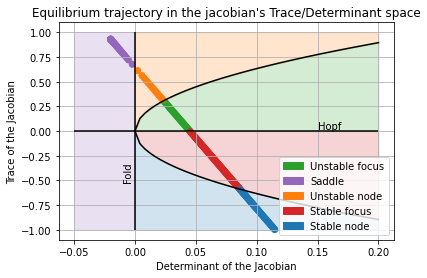

In [51]:
plt.scatter(det,trace, c=[EQUILIBRIUM_COLOR[n] for n in nature_legends])
plt.grid()
x = np.linspace(0,.2)
plt.plot(x, np.sqrt(4*x),color='k')
plt.plot(x, -np.sqrt(4*x),color='k')
plt.vlines(0, -1,1, color='k')
plt.hlines(0, -0.05,x.max(), color='k')
plt.text(-0.01, -0.5, 'Fold', rotation=90)
plt.text(0.15, 0.015, 'Hopf')

plt.gca().set(xlabel='Determinant of the Jacobian', ylabel='Trace of the Jacobian')
plt.fill_between(x,0,np.sqrt(4*x), color=EQUILIBRIUM_COLOR['Unstable focus'], alpha=0.2)
plt.fill_between(x,0,-np.sqrt(4*x), color=EQUILIBRIUM_COLOR['Stable focus'], alpha=0.2)
plt.fill_between(x,-np.sqrt(4*x),-1, color=EQUILIBRIUM_COLOR['Stable node'], alpha=0.2)
plt.fill_between(x,np.sqrt(4*x),1, color=EQUILIBRIUM_COLOR['Unstable node'], alpha=0.2)
plt.fill_between([-0.05,0],-1,1, color=EQUILIBRIUM_COLOR['Saddle'], alpha=0.2)
plt.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
               loc='lower right')
plt.title("Equilibrium trajectory in the jacobian's Trace/Determinant space")